In [1]:
import torch
import numpy as np
from tqdm import tqdm
from Bio import SeqIO
from esm.models.esmc import ESMC
from esm.models.esm3 import ESM3
from esm.sdk.api import ESMProtein, ESMProteinTensor, LogitsConfig
from esm.utils.sampling import _BatchedESMProteinTensor
import matplotlib.pyplot as plt
from datasets import load_dataset
import random

/home/ishan/miniforge3/envs/ecn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("lightonai/SwissProt-EC-leaf")
ds = ds.with_format("torch")

In [3]:
ds.keys()

dict_keys(['train', 'test', 'dev'])

In [4]:
ds['train'][0]

{'seq': 'MKFSEQWLRGWVSPQVDRDALVARLSMAGLEVDSVTPAAGVFSGVVVGEVLSTEQHPDADKLRVCQVSNGAETFQVVCGAPNVRPGLKIPFAMIGAELPGDFKIKKAKLRGVESNGMLCSQAELQIGEGNDGLMELPADASVGEDFRVYLDLEDASIEVDLTPNRGDCLSLAGLAREVGALYDAPVTRPVVMAVPAAHDEVRSVEVLAPAACPRYLGRVIRNVDLSRPTPLWMVERLRRAEVRSIDAAVDITNYVMLELGQPLHAFDLAEINGGIRVRMAEEGEKLVLLDGQEVSLRSDTLVVADHTRALAIAGVMGGEHSGVSATTRDVFLESAFFDQIAVAGKARSYGLHTDASHRYERGVDWQLAREAMERATGLLLEITGGEAGPIIETVSEQHLPSIAPITLRAQRITQMLGMEMDSAEVERLLNALGLKVSADGAGQWRVEVPSHRFDISLEVDLIEELARLYGYNRLPVRYPQARLAPQAKAEARSDLPELRRLLVARGYQEAITYSFIDPKQFELFNPGVEPLLLANPISNDMAAMRSSLWPGLVKALQHNLNRQQDRVRLFESGLRFVGQLEGLKQEPMIAGVVCGSRLPEGWAQGRDTVDFFDVKADVEAVLGFAGALDQFTFAPGKHPALHPGQTARIEREGREVGFIGAIHPELSKSLGLDRPVFVFELVLAEVALGKMPKFHELSRFPEVRRDLALIAHKDVAASAVLDVIRENAGEWLTDLRLFDVYQGKGIDTDRKSLAVGLTWQHPSRTLNDDEVNSTTQNILTSLEQRLNATLRK',
 'labels': tensor([309]),
 'labels_str': "['EC:6.1.1.20']",
 'id': 'Q3KEX7'}

In [5]:
X_train, y_train = ds['train']['seq'], ds['train']['labels']

In [6]:
X_train[0], X_train[14], y_train[0], y_train[14]

('MKFSEQWLRGWVSPQVDRDALVARLSMAGLEVDSVTPAAGVFSGVVVGEVLSTEQHPDADKLRVCQVSNGAETFQVVCGAPNVRPGLKIPFAMIGAELPGDFKIKKAKLRGVESNGMLCSQAELQIGEGNDGLMELPADASVGEDFRVYLDLEDASIEVDLTPNRGDCLSLAGLAREVGALYDAPVTRPVVMAVPAAHDEVRSVEVLAPAACPRYLGRVIRNVDLSRPTPLWMVERLRRAEVRSIDAAVDITNYVMLELGQPLHAFDLAEINGGIRVRMAEEGEKLVLLDGQEVSLRSDTLVVADHTRALAIAGVMGGEHSGVSATTRDVFLESAFFDQIAVAGKARSYGLHTDASHRYERGVDWQLAREAMERATGLLLEITGGEAGPIIETVSEQHLPSIAPITLRAQRITQMLGMEMDSAEVERLLNALGLKVSADGAGQWRVEVPSHRFDISLEVDLIEELARLYGYNRLPVRYPQARLAPQAKAEARSDLPELRRLLVARGYQEAITYSFIDPKQFELFNPGVEPLLLANPISNDMAAMRSSLWPGLVKALQHNLNRQQDRVRLFESGLRFVGQLEGLKQEPMIAGVVCGSRLPEGWAQGRDTVDFFDVKADVEAVLGFAGALDQFTFAPGKHPALHPGQTARIEREGREVGFIGAIHPELSKSLGLDRPVFVFELVLAEVALGKMPKFHELSRFPEVRRDLALIAHKDVAASAVLDVIRENAGEWLTDLRLFDVYQGKGIDTDRKSLAVGLTWQHPSRTLNDDEVNSTTQNILTSLEQRLNATLRK',
 'MERKEIESLFTRAREIRALVIGDLMLDEYLWGKAERISPEAPVQVVDVTREDLRLGGAGNVVNNLVALGCQVAVCSVIGGDENGSHLRHAFTGKGVDLTGVFEDPLRLTSKKTRVIAANQQIVRIDRESRDEISLEFEEKVLDFIAAEAARFNVILVSDYLKGVLTPRVLEAVCAAGRRLGIPVVVDPKGSDYGKYRGATI

In [7]:
y_max = max([y for y_list in y_train for y in y_list])
y_train = [torch.nn.functional.one_hot(y, y_max+1).sum(0) for y in y_train]
y_train = torch.stack(y_train)

In [9]:
print(len(X_train), y_train.shape)

178302 torch.Size([178302, 4793])


In [7]:
torch.nonzero(y_train[0]), torch.nonzero(y_train[14])

(tensor([[309]]),
 tensor([[1833],
         [2528]]))

Using ESM3 because if it works, we'd expect it to likely work with ESMC too. If it does work, then ESM3 preferable to be able to condition on sequence, structure, function, etc.
Failure cases are if it doesn't work with ESM3 but does with ESMC and data leakage from ESM3's multimodal training.
Leakage is likely real, so I need to do this with ESMC. Since they don't advertise it, the model probably doesn't work well for structure prediction, and topologically precise conditions for function probably aren't well modeled. The alternative is to get a new dataset of swissprot added since the old model was trained, and stratify for similarity maybe. Stratifying by similarity is probably necessary anyways, even for ESMC just to understand its impact.

In [8]:
esm = ESMC.from_pretrained("esmc_300m").to("cuda")

Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 33354.31it/s]
/home/ishan/miniforge3/envs/ecn/lib/python3.10/site-packages/esm/pretrained.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this e

In [11]:
def batched_protein_itr(X, y, batch_size=32):
    for i in range(0, len(X), batch_size):
        print(max([len(x) for x in X[i:i+batch_size]]))
        y_batch = y[i:i+batch_size]
        protein_sequences = [ESMProtein(sequence=x) for x in X[i:i+batch_size]]
        encoded_proteins = [esm.encode(p) for p in protein_sequences]
        batch_tensor = _BatchedESMProteinTensor(sequence=torch.stack([p.sequence for p in encoded_proteins]))
        yield batch_tensor, y_batch

In [29]:
logits_config = LogitsConfig(sequence=True, return_embeddings=True)
cls_embeddings = []
res_avg_embeddings = []
# for X_batch, y_batch in tqdm(batched_protein_itr(X_train, y_train)):
n_samples = 10000
sample_indices = random.sample(range(len(X_train)), n_samples)
# sample_indices = torch.arange(len(X_train))
for X_batch in tqdm([X_train[i] for i in sample_indices]):
    encoded_X = esm.encode(ESMProtein(sequence=X_batch))
    logits = esm.logits(encoded_X, logits_config)
    cls_embeddings.append(logits.embeddings[:, 0]) # embedding dim 960
    res_avg_embeddings.append(logits.embeddings[:, 1:-1].mean(1))
cls_embeddings = torch.cat(cls_embeddings)
res_avg_embeddings = torch.cat(res_avg_embeddings)
y_samples = y_train[sample_indices]


100%|██████████| 10000/10000 [03:42<00:00, 44.94it/s]


In [31]:
from esm_ecn.constants import DATA_FOLDER
from pathlib import Path
DATA_FOLDER = Path(DATA_FOLDER)
torch.save(cls_embeddings, DATA_FOLDER / "cls_embeddings.pt")
torch.save(res_avg_embeddings, DATA_FOLDER / "res_avg_embeddings.pt")
torch.save(y_samples, DATA_FOLDER / "y.pt")

In [51]:
match_indices = [torch.equal(y_samples[i], y_samples[1]) for i in range(len(y_samples))]
match_indices = torch.tensor(match_indices).nonzero().flatten()
print(match_indices)

tensor([   1,   78,  102,  158,  502,  660,  666,  735,  929, 1007, 1395, 1436,
        1697, 1847, 2015, 2602, 2634, 3556, 3605, 3807, 3974, 4116, 4928, 5173,
        5323, 5558, 5671, 5797, 6688, 6878, 6918, 7020, 7344, 7710, 7868, 8673,
        8751, 9029, 9300])


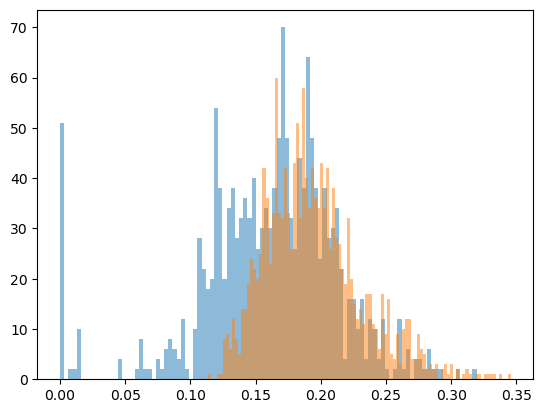

In [56]:
n_samples = len(match_indices)
non_match_indices = list(filter(lambda i: i not in match_indices, np.arange(len(y_samples))))
sample_indices = np.random.choice(non_match_indices, n_samples, replace=False)

distances_match = torch.cdist(cls_embeddings[match_indices], cls_embeddings[match_indices])
distances_non_match = torch.cdist(cls_embeddings[match_indices], cls_embeddings[sample_indices])

plt.hist(distances_match.flatten().cpu().numpy(), bins=100, alpha=0.5, label="match")
plt.hist(distances_non_match.flatten().cpu().numpy(), bins=100, alpha=0.5, label="non-match")
plt.show()

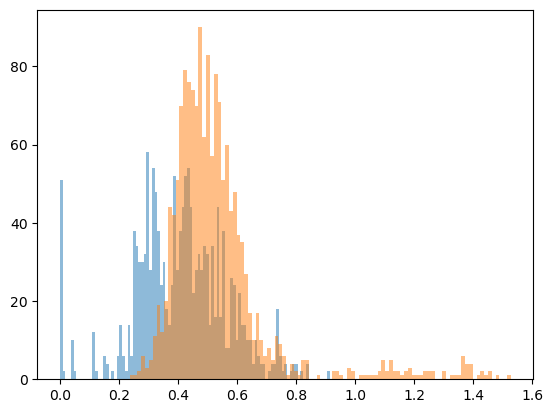

In [57]:
distances_match = torch.cdist(res_avg_embeddings[match_indices], res_avg_embeddings[match_indices])
distances_non_match = torch.cdist(res_avg_embeddings[match_indices], res_avg_embeddings[sample_indices])

plt.hist(distances_match.flatten().cpu().numpy(), bins=100, alpha=0.5, label="match")
plt.hist(distances_non_match.flatten().cpu().numpy(), bins=100, alpha=0.5, label="non-match")
plt.show()